<a href="https://colab.research.google.com/github/WianStipp/LSTM-For-Price-Prediction/blob/master/LSTM_ETHEUR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data Science Incubator - ML@LSE

## LSTM For Price Prediction - ETHEUR

## Preprocessing

We are going to follow a method similar to that in the Google tutorial because I think it is well layed out, consistent and easy to follow. That means if you don't understand something here, maybe check out the Google link since they may have more details there (and explanations). https://www.tensorflow.org/tutorials/structured_data/time_series#the_weather_dataset

As usual let's start by importing the required packages. We can also import the data and save it as a pandas dataframe. We have the data saved in a GitHib repository and can import it directly.

In [0]:
%tensorflow_version 2.x
import tensorflow as tf
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [0]:
url = 'https://raw.githubusercontent.com/WianStipp/LSTM-For-Price-Prediction/master/data/ETHEUR.csv'
dataframe = pd.read_csv(url, header=None, index_col=0)

Let's use a GPU.

Google Colab offers free GPUs and TPUs! It's best to take advantage of this (in this case we'll attach a GPU), otherwise training will take a very long time.

A GPU can be added by going to the menu and selecting:

Edit -> Notebook Settings -> Add accelerator (GPU)

Then run the following cell to confirm that the GPU is detected.

In [82]:
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [83]:
dataframe.shape

(21703, 1)

In [84]:
dataframe.head()

,1
0,
2017-05-30 23:00:00,196.50
2017-05-31 00:00:00,201.49
2017-05-31 01:00:00,206.11
2017-05-31 02:00:00,207.09
2017-05-31 03:00:00,205.50


In [0]:
dataframe = dataframe.rename(columns={1:"open"})
dataframe['datetime'] = pd.to_datetime(dataframe.index)
dataframe = dataframe.set_index('datetime')

In [86]:
dataframe.head()

,open
datetime,
2017-05-30 23:00:00,196.50
2017-05-31 00:00:00,201.49
2017-05-31 01:00:00,206.11
2017-05-31 02:00:00,207.09
2017-05-31 03:00:00,205.50


Okay so we clearly have some clean time series data. We have hourly data from ETHEUR (ETH vs EUR) from 2017 until now! Let's plot it to get a better idea of what we're working with.

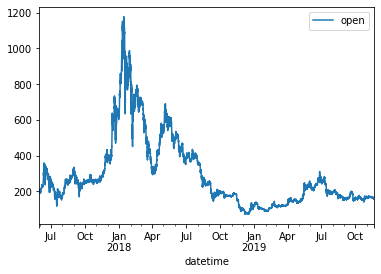

In [87]:
dataframe.plot()

We want to convert the dataframe into returns rather than the actual price values. To compute the return on the hour we do:

$$ R_{t+1} = \frac{S_{t+1}}{S_t} - 1 $$

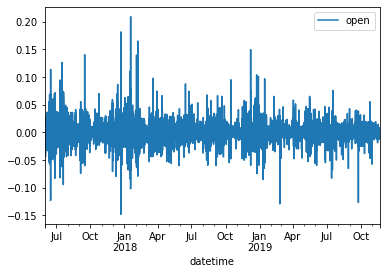

In [88]:
dataframe_pct = (dataframe / dataframe.shift(1) - 1)
dataframe_pct.plot()

At this point you might have an error in your data (there is one in the BTCUSD dataset). However, for ETHEUR it seems fine.

Let's use the function from the Google tutorial to split our data into windows which will be fed in to the model.

In [0]:
def univariate_data(dataset, start_index, end_index, history_size, target_size):
  data = []
  labels = []

  start_index = start_index + history_size
  if end_index is None:
    end_index = len(dataset) - target_size

  for i in range(start_index, end_index):
    indices = range(i-history_size, i)
    # Reshape data from (history_size,) to (history_size, 1)
    data.append(np.reshape(dataset[indices], (history_size, 1)))
    labels.append(dataset[i+target_size])
  return np.array(data), np.array(labels)

In [90]:
TRAIN_SPLIT = dataframe_pct.shape[0] * 0.9
TRAIN_SPLIT = round(TRAIN_SPLIT)
print(TRAIN_SPLIT)

19533


In [0]:
tf.random.set_seed(13)

Let's now start working with numpy arrays because they are going to be more useful to do calculations with.

In [0]:
data = dataframe_pct.values

In [0]:
past_history = 40
future_target = 0

X_train, y_train = univariate_data(data,
                                           0, TRAIN_SPLIT,
                                           past_history,
                                           future_target)

X_val, y_val = univariate_data(data, TRAIN_SPLIT, None,
                                       past_history,
                                       future_target)

In [95]:
print(X_train.shape,"<- X, Y-> ", y_train.shape)

(19493, 40, 1) <- X, Y->  (19493, 1)


This is what the univariate data returns looks like:

In [96]:
print ('Single window of past history')
print (X_train[0])
print ('\n Target price to predict')
print (y_train[0])

Single window of past history
[[            nan]
 [ 2.53944020e-02]
 [ 2.29291776e-02]
 [ 4.75474261e-03]
 [-7.67782124e-03]
 [ 5.35279805e-04]
 [-5.34993434e-04]
 [-2.67639903e-02]
 [-2.06500000e-02]
 [ 1.08745597e-02]
 [ 1.42929293e-02]
 [ 1.74276751e-03]
 [ 3.08181728e-03]
 [-4.95540139e-04]
 [ 3.05404065e-02]
 [-1.36149331e-02]
 [ 1.19006975e-02]
 [-4.19337736e-03]
 [-2.22168441e-02]
 [-7.57388248e-03]
 [-4.88826816e-03]
 [ 3.95989975e-03]
 [ 1.70752409e-02]
 [ 7.85430269e-04]
 [-1.81488203e-03]
 [ 7.37100737e-03]
 [-4.04878049e-03]
 [-4.89787922e-05]
 [ 2.35109718e-03]
 [ 1.37314308e-02]
 [ 5.68811762e-03]
 [-4.93696976e-03]
 [ 1.92678227e-03]
 [ 1.44230769e-02]
 [-1.89099526e-02]
 [-4.83068451e-04]
 [-4.34971727e-03]
 [ 1.30576186e-02]
 [-1.22664111e-02]
 [-5.48171146e-03]]

 Target price to predict
[-0.00248768]


Let's take the awesome function from the Google tutorial with which we can visualise what we need to predict.

In [0]:
def create_time_steps(length):
  time_steps = []
  for i in range(-length, 0, 1):
    time_steps.append(i)
  return time_steps

In [0]:
def show_plot(plot_data, delta, title):
  labels = ['History', 'True Future', 'Model Prediction']
  marker = ['.-', 'rx', 'go']
  time_steps = create_time_steps(plot_data[0].shape[0])
  if delta:
    future = delta
  else:
    future = 0

  plt.title(title)
  for i, x in enumerate(plot_data):
    if i:
      plt.plot(future, plot_data[i], marker[i], markersize=10,
               label=labels[i])
    else:
      plt.plot(time_steps, plot_data[i].flatten(), marker[i], label=labels[i])
  plt.legend()
  plt.xlim([time_steps[0], (future+5)*2])
  plt.xlabel('Time-Step')
  plt.show()
  return plt

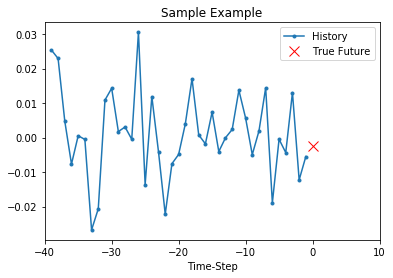

In [99]:
show_plot([X_train[0], y_train[0]], 0, 'Sample Example')
plt.show()

Let's first build a baseline model

## Baseline

In [0]:
def baseline(history):
  return np.mean(history)

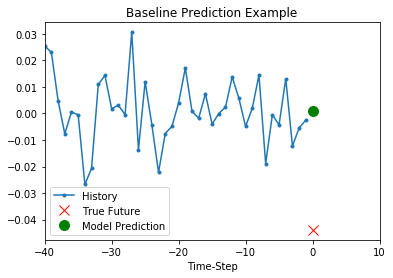

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.6/dist-packages/matplotlib/pyplot.py'>

In [101]:
show_plot([X_train[1], y_train[1], baseline(X_train[1])], 0,
           'Baseline Prediction Example')

## LSTM

Now that we have a baseline, we can now train a LSTM model (a type of RNN) to try to see if we can improve on the baseline score.

In [0]:
BATCH_SIZE = 512
BUFFER_SIZE = 10000

train_tensor = tf.data.Dataset.from_tensor_slices((X_train, y_train))
train_tensor = train_tensor.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_tensor = tf.data.Dataset.from_tensor_slices((X_val, y_val))
val_tensor = val_tensor.batch(BATCH_SIZE).repeat()

In [0]:
simple_lstm_model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(50, input_shape=X_train.shape[-2:], return_sequences=True),
    tf.keras.layers.Dropout(.2),
    tf.keras.layers.LSTM(100, input_shape=X_train.shape[-2:], return_sequences=False),
    tf.keras.layers.Dropout(.2),
    tf.keras.layers.Dense(1)
])

simple_lstm_model.compile(optimizer='Nadam', loss='mae')

In [0]:
simple_lstm_model.reset_states()

Let's make a sample prediction, to check the output of the model. 

In [35]:
for x, y in val_tensor.take(1):
    print(simple_lstm_model.predict(x).shape)

(512, 1)


The sample prediction seems to have worked. It has predicted 512 prices from 512 examples of inputs (which are windows of 40 prices). Make sure you understand the dimensions we are working with because we are now using tensors.

Let's fit the model

In [36]:
EVALUATION_INTERVAL = 8000
EPOCHS = 3

simple_lstm_model.fit(train_tensor, epochs=EPOCHS,
                      steps_per_epoch=EVALUATION_INTERVAL,
                      validation_data=val_tensor, validation_steps=50)

Train for 8000 steps, validate for 50 steps
Epoch 1/3
   1/8000 [..............................] - ETA: 4:02:37

KeyboardInterrupt: ignored

We can load a (sort of) pretrained model to save time.

In [56]:
from google.colab import files
files.upload()

Saving etherium.h5 to etherium.h5


{'etherium.h5': b'\x89HDF\r\n\x1a\n\x00\x00\x00\x00\x00\x08\x08\x00\x04\x00\x10\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xff\xff\xff\xff\xff\xff\xff\xff\x18\x8f\r\x00\x00\x00\x00\x00\xff\xff\xff\xff\xff\xff\xff\xff\x00\x00\x00\x00\x00\x00\x00\x00`\x00\x00\x00\x00\x00\x00\x00\x01\x00\x00\x00\x00\x00\x00\x00\x88\x00\x00\x00\x00\x00\x00\x00\xa8\x02\x00\x00\x00\x00\x00\x00\x01\x00\x07\x00\x01\x00\x00\x00\x18\x00\x00\x00\x00\x00\x00\x00\x10\x00\x10\x00\x00\x00\x00\x00 \x03\x00\x00\x00\x00\x00\x00h\x01\x00\x00\x00\x00\x00\x00TREE\x00\x00\x01\x00\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\x00\x00\x00\x00\x00\x00\x00\x00\x00\x18\x00\x00\x00\x00\x00\x00\x18\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00

In [0]:
simple_lstm_model = tf.keras.models.load_model("etherium.h5")

In [106]:
simple_lstm_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 40, 50)            10400     
_________________________________________________________________
dropout (Dropout)            (None, 40, 50)            0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 100)               60400     
_________________________________________________________________
dropout_1 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense (Dense)                (None, 1)                 101       
Total params: 70,901
Trainable params: 70,901
Non-trainable params: 0
_________________________________________________________________


## Check on validation data

In [0]:
val_dataframe = dataframe[TRAIN_SPLIT:]
val_dataframe_pct = val_dataframe.pct_change()[1:]
val_dataframe = val_dataframe[1:]
val_dataframe_CHECK = val_dataframe

In [108]:
val_dataframe_CHECK.shape

(2169, 1)

Let's look at a prediction for a certain instance

In [65]:
simple_lstm_model.predict(val_dataframe_pct["open"].values[0:0+40].reshape(1,40,1))[0][0]

0.0006041258

In [109]:
val_dataframe_pct.iloc[0]

open   -0.008914
Name: 2019-08-22 21:00:00, dtype: float64

In [112]:
#Check the index lines up
np.count_nonzero(val_dataframe_CHECK.index != val_dataframe_pct.index)

0

In [113]:
val_dataframe_CHECK.head()

,open
datetime,
2019-08-22 21:00:00,173.44
2019-08-22 22:00:00,173.76
2019-08-22 23:00:00,173.64
2019-08-23 00:00:00,175.16
2019-08-23 01:00:00,172.11


In [114]:
total_return = []
prediction = []
account_size = 10000


for i in range(val_dataframe_CHECK.shape[0]-41):
  risk = 0.01*account_size

  if i == 0:
    print(val_dataframe_CHECK.index[0])
  if i == val_dataframe_CHECK.shape[0]-41:
    print(val_dataframe_CHECK.index[val_dataframe_CHECK.shape[0]-41])

  if np.abs(simple_lstm_model.predict(val_dataframe_pct["open"].values[i:i+40].reshape(1,40,1))[0][0]) > 0.001:
    model_prediction = (simple_lstm_model.predict(val_dataframe_pct["open"].values[i:i+40].reshape(1,40,1))[0][0]+1)*val_dataframe_CHECK.values[i+40]
    S_0 = val_dataframe_CHECK.values[i+40]

    if model_prediction > (S_0):
      S_1 = val_dataframe_CHECK.values[i+41]
      prediction.append(S_1)
      total_return.append((S_1[0] - S_0[0]))
      account_size += total_return[-1]*risk/100

    if model_prediction < (S_0):
      S_1 = val_dataframe_CHECK.values[i+41]
      prediction.append(S_1)
      total_return.append((S_0[0] - S_1[0]))
      account_size += total_return[-1]*risk/100
    
    else:
      continue

2019-08-22 21:00:00


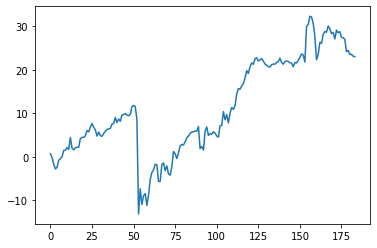

In [115]:
cumsum_val = np.cumsum(total_return)
plt.plot(cumsum_val)

In [0]:

#